In [1]:
!pip install stable_baselines3
!pip install quantstats

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd

import gym
import gym_anytrading
import quantstats as qs
from gym_anytrading.envs import TradingEnv, ForexEnv, StocksEnv, Actions, Positions 
from gym_anytrading.datasets import FOREX_EURUSD_1H_ASK, STOCKS_GOOGL
from stable_baselines3 import A2C,PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.ppo import MlpPolicy
import matplotlib.pyplot as plt


In [25]:
# df = gym_anytrading.datasets.STOCKS_GOOGL.copy()

# window_size = 10
# start_index = window_size
# end_index = len(df)

# env_maker = lambda: gym.make(
#     'stocks-v0',
#     df = df,
#     window_size = window_size,
#     frame_bound = (start_index, end_index)
# )

# env = DummyVecEnv([env_maker])

The *window_size* specifies how many previous timesteps our trading bot has as reference points when it makes its next trade. The *frame_bound* specifies the start and end of our df. The first parameter on the *frame_bound* should always be equal to the *window_size* so that it has the five sets of previous data. For the second parameter, you can adjust it to any value of your choice depending on your data.


In [67]:
df = gym_anytrading.datasets.STOCKS_GOOGL.copy()
window_size = 10
start_index = window_size
end_index = len(df)

def my_process_data(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Low'].to_numpy()[start:end]
    #customize your features here 
    signal_features = env.df.loc[:, ['Close', 'Open', 'High', 'Low']].to_numpy()[start:end]
    return prices, signal_features


class MyForexEnv(ForexEnv):
    _process_data = my_process_data


env = MyForexEnv(df=STOCKS_GOOGL, window_size=10, frame_bound=(10, len(STOCKS_GOOGL)))


In [68]:


model = PPO(MlpPolicy, env, verbose=1)
model.learn(total_timesteps=1000)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 943  |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 2048 |
-----------------------------


In [69]:
#env = env_maker()
observation = env.reset()

while True:
    observation = observation[np.newaxis, ...]

    # action = env.action_space.sample()
    action, _states = model.predict(observation)
    observation, reward, done, info = env.step(action)

    # env.render()
    if done:
        print("info:", info)
        break


info: {'total_reward': -4359175.019999985, 'total_profit': 0.3356665295547344, 'position': 0}


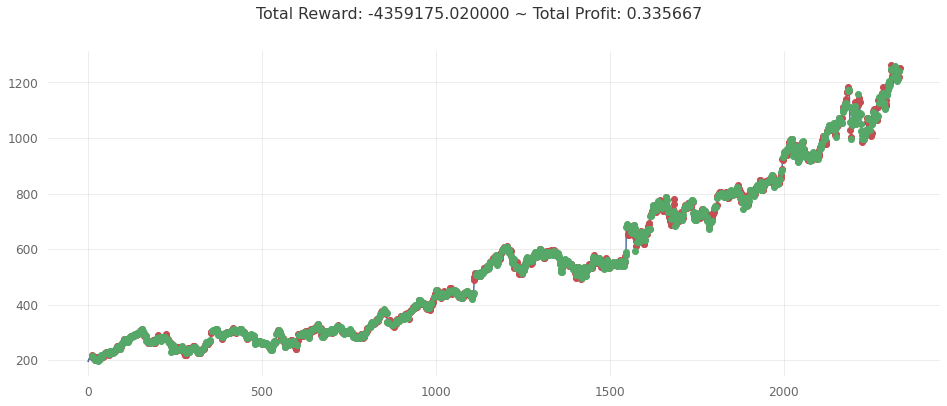

In [70]:
plt.figure(figsize=(16, 6))
env.render_all()
plt.show()

[Performance Metrics]

                           Strategy
-------------------------  ----------
Start Period               2009-06-10
End Period                 2018-08-29
Risk-Free Rate             0.0%
Time in Market             25.0%

Cumulative Return          -67.02%
CAGR﹪                     -11.33%

Sharpe                     -0.64
Prob. Sharpe Ratio         2.69%
Smart Sharpe               -0.64
Sortino                    -0.88
Smart Sortino              -0.88
Sortino/√2                 -0.62
Smart Sortino/√2           -0.62
Omega                      0.79

Max Drawdown               -70.14%
Longest DD Days            3334
Volatility (ann.)          16.62%
Calmar                     -0.16
Skew                       0.14
Kurtosis                   30.12

Expected Daily %           -0.05%
Expected Monthly %         -0.99%
Expected Yearly %          -10.5%
Kelly Criterion            -11.86%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.76%
Expected Shortfall (cVaR

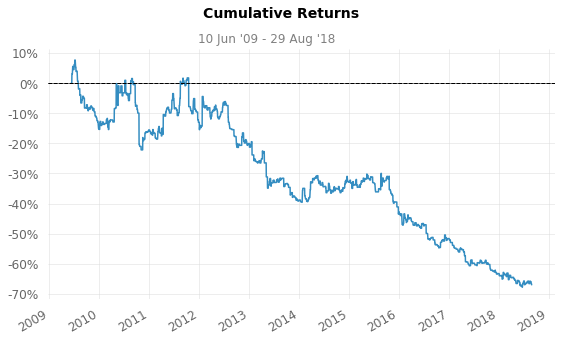

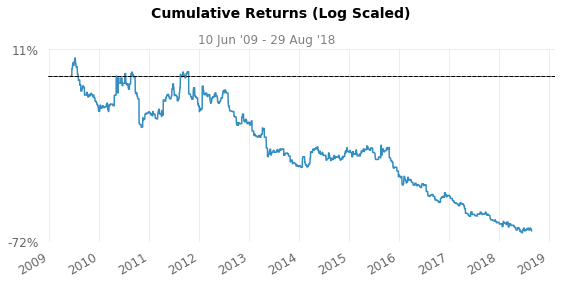

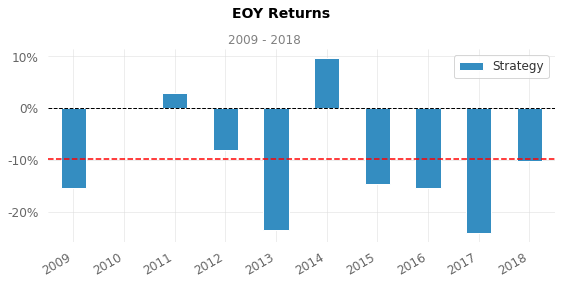

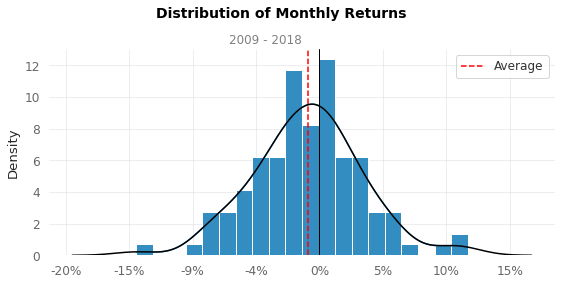

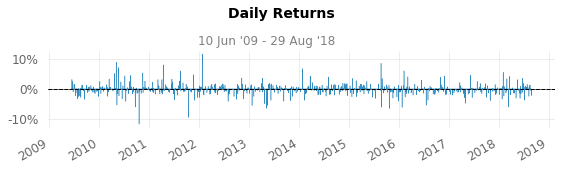

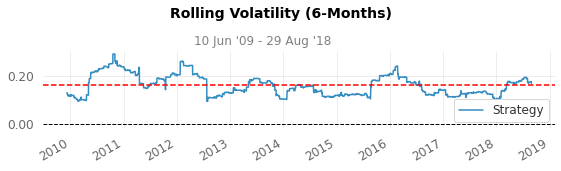

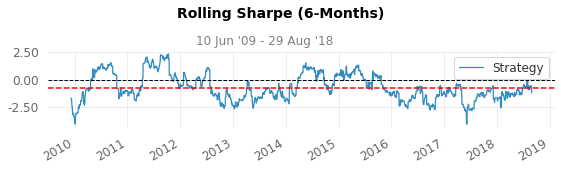

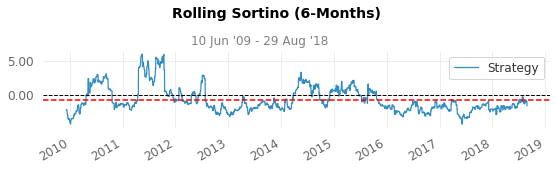

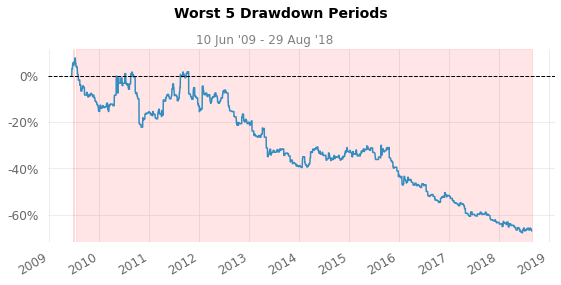

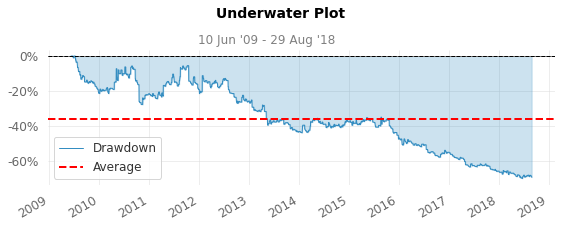

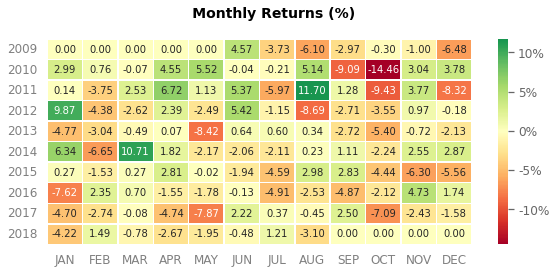

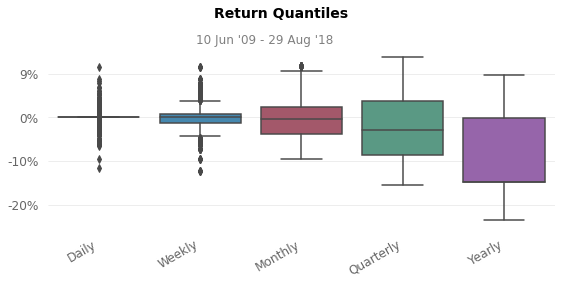

In [71]:
qs.extend_pandas()

net_worth = pd.Series(env.history['total_profit'], index=df.index[start_index + 1 :end_index])
returns = net_worth.pct_change().iloc[1:]

qs.reports.full(returns)